# Generalized Lotka Volterra

**In this notebook we illustrate the use of DataGeneratorObservations to cope with non aligned datasets and the use of vectorial adaptative weights, where we have weights for each equation of the dynamic and for each channel of observations**

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = \alpha_iu_i(t)
-\sum_j\gamma_{j,i}u_j(t) - \beta_i\sum_{i'}u_{i'}(t), i\in\{1, 2, 3\}
$$
where $\alpha$ are the growth rates, $\gamma$ are the interactions terms and $\beta$ and the capacity terms.

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Optionnally force CPU

In [2]:
# import os
# os.environ["JAX_PLATFORMS"] = "cpu"

## Create some observations with ground truth from scipy solver

In [3]:
# initial conditions for each species
import jax.numpy as jnp
import numpy as onp

N_0 = onp.array([10.0, 7.0, 4.0])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that interaction with oneself is 0
# NOTE minus sign
interactions = -jnp.array([[0, 0.001, 0.001], [0.001, 0, 0.001], [0.001, 0.001, 0]])

W1211 09:52:53.631881   14215 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1211 09:52:53.635722   12957 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [4]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
# NOTE the following line is not accurate as it skips one batch


def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)
    for i in range(N):
        dydt[i] = y[i] * (
            alpha[i]
            - beta[i] * np.sum(y)
            - np.sum([gamma[j, i] * y[j] for j in range(N)])
        )

    dydt_log = dydt / y

    return dydt_log


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4]

# Define time points
ts = onp.linspace(0, 1, 100)
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [5]:
df_scipy = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "Method": "Scipy solver",
    }
    | {f"N{i + 1}": y[:, i] for i in range(3)},
)

In [6]:
observations = df_scipy[["t", "N1", "N2", "N3"]].values

**Be sure to normalize observations**

In [7]:
idx_N1 = np.sort(np.random.choice(onp.arange(100), size=30, replace=False))
obs_N1 = (observations[idx_N1, 0] / Tmax, observations[idx_N1, 1])
idx_N2 = np.sort(np.random.choice(onp.arange(100), size=66, replace=False))
obs_N2 = (observations[idx_N2, 0] / Tmax, observations[idx_N2, 2])
idx_N3 = np.sort(np.random.choice(onp.arange(100), size=77, replace=False))
obs_N3 = (observations[idx_N3, 0] / Tmax, observations[idx_N3, 3])
# plt.plot(obs_N1[0], obs_N1[1])
# plt.plot(obs_N2[0], obs_N2[1])
# plt.plot(obs_N3[0], obs_N3[1])

# plt.show()

## Start the GLV resolution with jinns

Import our package

In [8]:
import jinns

Import other dependencies

In [9]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that the output is 3, for the 3 populations.

In [10]:
eqx_list = (
    (eqx.nn.Linear, 1, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 3),
    (jnp.exp,),
)
key, subkey = random.split(key)

Create a DataGenerator object

In [11]:
nt = 5000
method = "uniform"
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, temporal_batch_size=512, method=method
)

Create a DataGeneratorObservations object. We will use the feature passing multiple datasets.

In [61]:
d = (1, 2, 3)
e = (1, 2)
tuple(0 for _, __ in zip(d, e))

(0, 0)

In [68]:
key, subkey = random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=None,
    observed_pinn_in=(obs_N1[0], obs_N2[0], obs_N3[0]),
    observed_values=(obs_N1[1], obs_N2[1], obs_N3[1]),
)

Initialize a **jinns** neural network

In [69]:
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

### Model parameters

Then, we proceed to define the set of parameters as required by the losses' `equation(self, ...)` methods. This is a `jinns.paramaters.Params` object, with two fields for
 1. `nn_params`: the neural network parameters 
 2. `eq_params`: the equation parameters

In [70]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "carrying_capacities": carrying_capacities,
        "growth_rates": growth_rates,
        "interactions": interactions,
    },
)

Visualize the output of the neural networks with the random initialization.

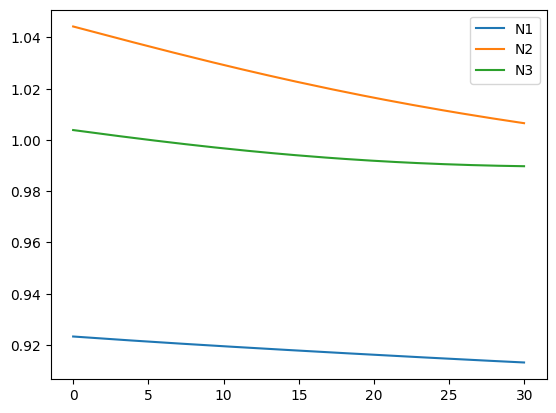

In [71]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)

plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 0],
    label="N1",
)
plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 1],
    label="N2",
)
plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 2],
    label="N3",
)

plt.legend()

### First resolution with observations only (sanity check)

**Don't forget obs_slice**

Initialization time: 2.414896011352539

Compilation took
 4.388458013534546 

[train] Iteration 0: loss value = 1271.076171875
[train] Iteration 1000: loss value = 0.06890749931335449

Stopping main optimization loop, cause: max iteration is reached

Training took
 1.2409553527832031 


Final iteration 2000: train loss value = 0.02366180345416069


<Axes: xlabel='t'>

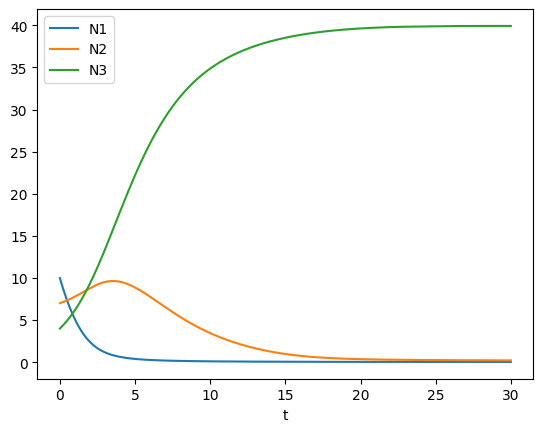

In [73]:
from jinns.data import append_obs_batch
import optax

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=jinns.loss.LossWeightsODE(
        initial_condition=1.0, observations=(1.0, 1.0, 1.0)
    ),
    dynamic_loss=None,
    initial_condition=(float(tmin), jnp.array([N_0[0], N_0[1], N_0[2]])),
    params=init_params,
    obs_slice=(jnp.s_[0:1], jnp.s_[1:2], jnp.s_[2:3]),
)

params = init_params
tx = optax.adamw(learning_rate=1e-3)
key, subkey = random.split(key)
(params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _) = (
    jinns.solve(
        init_params=params,
        data=train_data,
        obs_data=obs_data,
        optimizer=tx,
        loss=loss,
        n_iter=2000,
        key=subkey,
    )
)
u_est = vmap(lambda t: u(t, params), (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, method=method
)

ts = val_data.times.sort(axis=0).squeeze()
df = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "N1": u_est(ts)[:, 0],
        "N2": u_est(ts)[:, 1],
        "N3": u_est(ts)[:, 2],
        "Method": "PINN",
    },
)
df.plot(x="t")

## Loss construction

We construct a LossODE for GeneralizedLotkaVolterra

In [74]:
from jinns.loss import ODE


class GLV_eq1(ODE):
    """Tmax is inherited via ODE"""

    def equation(self, t, u, params):
        u1 = lambda t: jnp.log(u(t, params))[0]
        du1_dt = jax.grad(u1)(t).squeeze()
        carrying_term = params.eq_params.carrying_capacities[0] * jnp.sum(u(t, params))
        interaction_term = jnp.sum(params.eq_params.interactions[0] * u(t, params))
        return (
            du1_dt.squeeze()
            + self.Tmax
            * (-params.eq_params.growth_rates[0] + interaction_term + carrying_term)
        )[None]


class GLV_eq2(ODE):
    """Tmax is inherited via ODE"""

    def equation(self, t, u, params):
        u2 = lambda t: jnp.log(u(t, params))[1]
        du2_dt = jax.grad(u2)(t).squeeze()
        carrying_term = params.eq_params.carrying_capacities[1] * jnp.sum(u(t, params))
        interaction_term = jnp.sum(params.eq_params.interactions[1] * u(t, params))
        return (
            du2_dt.squeeze()
            + self.Tmax
            * (-params.eq_params.growth_rates[1] + interaction_term + carrying_term)
        )[None]


class GLV_eq3(ODE):
    """Tmax is inherited via ODE"""

    def equation(self, t, u, params):
        u3 = lambda t: jnp.log(u(t, params))[2]
        du3_dt = jax.grad(u3)(t).squeeze()
        carrying_term = params.eq_params.carrying_capacities[2] * jnp.sum(u(t, params))
        interaction_term = jnp.sum(params.eq_params.interactions[2] * u(t, params))
        return (
            du3_dt.squeeze()
            + self.Tmax
            * (-params.eq_params.growth_rates[2] + interaction_term + carrying_term)
        )[None]


dyn_loss_eq1 = GLV_eq1(Tmax=Tmax)
dyn_loss_eq2 = GLV_eq2(Tmax=Tmax)
dyn_loss_eq3 = GLV_eq3(Tmax=Tmax)

In [75]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=(1, 1, 1), initial_condition=Tmax, observations=(1.0, 1.0, 1.0)
)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=(dyn_loss_eq1, dyn_loss_eq2, dyn_loss_eq3),
    initial_condition=(float(tmin), jnp.array([N_0[0], N_0[1], N_0[2]])),
    params=init_params,
    update_weight_method="soft_adapt",
    keep_initial_loss_weight_scales=True,
    obs_slice=(jnp.s_[0:1], jnp.s_[1:2], jnp.s_[2:3]),
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_abstract_loss.py:77: UserWarning: Loss weights out from update_weight_method will still be multiplied by the initial input loss_weights
  warnings.warn(


In [76]:
# Testing the loss function

train_data, batch = train_data.get_batch()
obs_data, obs_batch = obs_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, append_obs_batch(batch, obs_batch))
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val}' for key, val in d.items()} }")

total loss: 5624.990234375
Individual losses: {'dyn_loss': '(Array(0.20329061, dtype=float32), Array(177.76115, dtype=float32), Array(497.774, dtype=float32))', 'initial_condition': '(Array(126.833626, dtype=float32),)', 'observations': '(Array(1.4109163, dtype=float32), Array(14.435326, dtype=float32), Array(1128.3964, dtype=float32))'}


## Learning the neural network parameters

The learning process here considers known equation parameters `eq_params`. We thus only update `nn_params`.

In the following cells, we define the necessary object for optimization of the 
`loss` we just defined. Namely, an `optax.GradientTransformation` which is the optimizer we'll use for 
updating `params` throughout. Here it is simply Adam with an exponential weight decay.


In [78]:
params = init_params

In [79]:
# Optimizer
import optax

start_learning_rate = 1e-3
# Exponential decay of the learning rate.
scheduler = optax.linear_schedule(
    init_value=start_learning_rate,
    transition_begin=20000,
    transition_steps=30000,
    end_value=1e-4,
)

# tx = optax.chain(
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0),
# )
tx = optax.adamw(learning_rate=scheduler)

In [80]:
n_iter = int(60000)

In [81]:
key, subkey = random.split(key)

In [82]:
(
    params,
    total_loss_list,
    loss_by_term_dict,
    data,
    loss,
    _,
    _,
    stored_weight_terms,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=params,
    data=train_data,
    obs_data=obs_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    key=subkey,
)

Initialization time: 2.637000560760498

Compilation took
 9.934016942977905 

[train] Iteration 0: loss value = 5624.95654296875
[train] Iteration 1000: loss value = 86.51237487792969
[train] Iteration 2000: loss value = 69.158935546875
[train] Iteration 3000: loss value = 64.99877166748047
[train] Iteration 4000: loss value = 39.63581848144531
[train] Iteration 5000: loss value = 490.23193359375
[train] Iteration 6000: loss value = 28.293506622314453
[train] Iteration 7000: loss value = 25.754955291748047
[train] Iteration 8000: loss value = 22.39131736755371
[train] Iteration 9000: loss value = 18.34381866455078
[train] Iteration 10000: loss value = 19.58498764038086
[train] Iteration 11000: loss value = 20.187759399414062
[train] Iteration 12000: loss value = 127.31586456298828
[train] Iteration 13000: loss value = 11.457742691040039
[train] Iteration 14000: loss value = 6.276544570922852
[train] Iteration 15000: loss value = 4.198991775512695
[train] Iteration 16000: loss value = 4

## Results

Plot the loss values

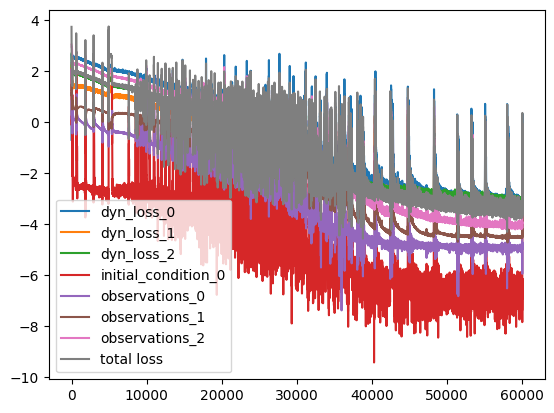

In [83]:
for loss_name, loss_values in loss_by_term_dict.items():
    if isinstance(loss_values, tuple):
        for i, lv in enumerate(loss_values):
            plt.plot(jnp.log10(lv), label=loss_name + "_" + str(i))
    else:
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Let's also visualize the loss weight values along the iterations

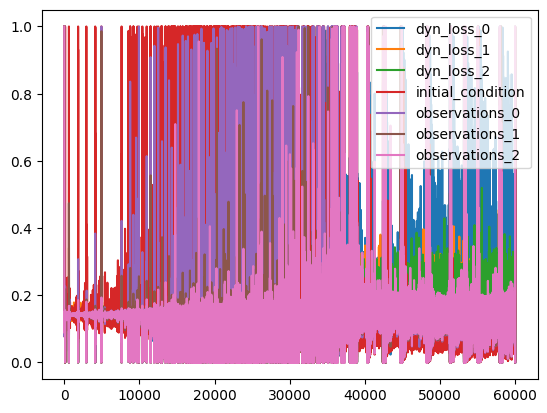

In [84]:
for loss_name, weight_values in stored_weight_terms.items():
    if isinstance(weight_values, tuple):
        for i, wv in enumerate(weight_values):
            plt.plot(wv, label=loss_name + "_" + str(i))
    else:
        plt.plot(
            weight_values / Tmax, label=loss_name
        )  # NOTE we divide by Tmax the loss_init_condition because it is articificially increased thanks to `keep_initial_loss_weight_scales`
# plt.ylim(0, 1)
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

<Axes: xlabel='t'>

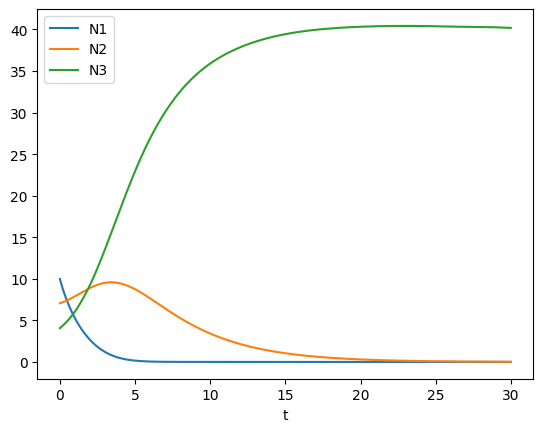

In [85]:
import pandas as pd

u_est = vmap(lambda t: u(t, params), (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, method=method
)


ts = val_data.times.sort(axis=0).squeeze()
df = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "N1": u_est(ts)[:, 0],
        "N2": u_est(ts)[:, 1],
        "N3": u_est(ts)[:, 2],
        "Method": "PINN",
    },
)
df.plot(x="t")

## Compare with the scipy solver
Code from Lorenzo Sala

In [86]:
import numpy as np
from scipy.integrate import odeint

# NOTE the following line is not accurate as it skips one batch


def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)

    for i in range(N):
        dydt[i] = y[i] * (
            alpha[i]
            - beta[i] * np.sum(y)
            - np.sum([gamma[j][i] * y[j] for j in range(N)])
        )

    dydt_log = dydt / y

    return dydt_log


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4]

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [87]:
# comparative plots
df_scipy = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "Method": "Scipy solver",
    }
    | {f"N{i + 1}": y[:, i] for i in range(3)},
)

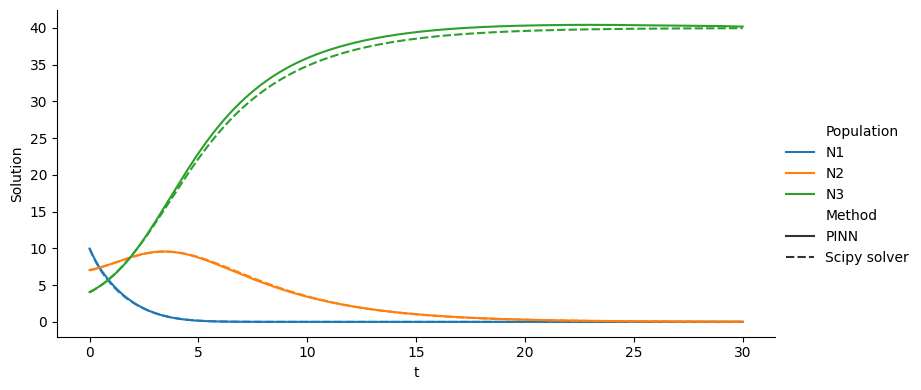

In [90]:
import seaborn as sns

df_plot = pd.concat((df, df_scipy)).melt(
    id_vars=["Method", "t"], var_name="Population", value_name="Solution"
)
sns.relplot(
    df_plot,
    kind="line",
    x="t",
    y="Solution",
    hue="Population",
    style="Method",
    height=4,
    aspect=2,
)

# Conclusion

We have shown how to use `LossODE` for system of ODEs. The results are satisfying although they could be improved by tweaking the network's architecture, learning rate and optimizers. Obviously, in the simple *forward problem* setting, the approach is not competitive compared to more standard and basic approaches. However, it paves the way for using PINN in an *inverse problem* when we have partial observation of the solution and wish to learn `params.eq_params`.